## Run de novo motif analysis on different subsets of TSS.
1. Load the peak expression file, and the annotation file. 
2. Average the BMDM response.
3. Filter for greater than 1CPM and >2kb Distance to Nearest transcript
4. For each tissue  
    a. Create 'Tissue Enriched' peaks by getting a z-score > 2 (log2 CPM)   
    b. Save the anno_peaks filtered on these peaks  
    c. Retrieve the sample peaks of this respective tissue (retrieve_tss)  
    d. Merge thes sample peak files from those tissues.  
    c. Use this merged file for Homer motif finding with GC normalization


In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../../parameters/params.yaml'
import yaml
import sys
import os
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

#data_folder = doc['data_folder']
#tissues = doc['tissues'].split(',')
#sys.path.append(doc['pipeline_path'])
ref_fa = doc['GENOME_FA']
#anno_gff=doc['annotation']
#mRNA_peak_file = doc["mRNA_peak_file"]
#tss_annotation = doc['tss_annotation']


import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from os.path import join
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
#from Homer import *

homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


/data2/resources/software/homer/v4.11_10242019/bin//homer


In [2]:
from scipy.stats import zscore

In [3]:
import click
from collections import defaultdict

In [4]:
from tss.utils import wrap_findMotifs
from tss.data.data_io import read_bed_file, write_bed_file, read_peak_file
from tss.utils import wrap_findMotifs
from tss.data import data_io
from tss.data.tissues_collapse import merge_columns
from tss.utils import Homer
from tss.visualize.fig_utils import helper_save

params {'PREFIX': 'ncbi_pice_103', 'ROOT_DIR': '/data/isshamie/TSS/', 'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/', 'DATA_PROCESSED_DIR': '/data/isshamie/TSS/TSS/data/processed/', 'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/', 'PIPELINE': '/data/isshamie/TSS/tss', 'GENOME_DIR': '/data/isshamie/genome', 'GENOME_FA': '/data/isshamie/genome/picr.fa', 'GENOME_GFF3': '/data/isshamie/genome/updated_final_sort.gff3', 'GENOME_GTF': '/data/isshamie/genome/updated_final_sort.gtf', 'TISSUES': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Intestine,', 'META_FILE': '/data/isshamie/TSS/TSS/parameters/raw_metaSamples.tsv'}
fig_utils from mplh
/data2/resources/software/homer/v4.11_10242019/bin//


In [5]:
os.chdir(doc["results"])
genome="alt"
outdir= join("v02_de_novo_motifs",genome)
data_dir = join(doc["results"], genome)
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
prom_enr_dir = join(outdir,'promoter_enriched')
if not os.path.exists(prom_enr_dir):
    os.mkdir(prom_enr_dir)

## Load peak eTSS and expression

In [6]:
tissue_expr_f = join(data_dir,"tissues_collapse/tissues.merge.peaksexpression")
peak_anno_f = join(data_dir, "merged","peaks_with_tss_distances_size1.peak")
merged_f = join(data_dir, "merged","samples.merge")
eTSS_f = join(data_dir, "eTSS","TSS.exp.bed")
eTSS_meta_f = join(data_dir, "eTSS","TSS.meta.tsv")

In [7]:
meta_df = pd.read_csv(eTSS_meta_f,sep='\t', index_col=0)
meta_df.head()

,Tissues,cs,CHO ATAC Region,ID,Gene,Gene ID,Transcript,Is Experimental,has ATAC
p2@Bmp4_XM_027386529.1,"Kidney,Lung,Brain,FemaleReproductive,Muscle,Mi...",0b00,NaN,90264.0,Bmp4,NaN,XM_027386529.1,1,0
p3@Bmp4_XM_027386529.1,"Kidney,Lung,Brain,FemaleReproductive,Muscle,Mi...",0b00,NaN,181215.0,Bmp4,NaN,XM_027386529.1,1,1
p1@Bmp4_XM_027386529.1,"Kidney,Lung,Brain,FemaleReproductive,Muscle,Mi...",0b11,NaN,348823.0,Bmp4,NaN,XM_027386529.1,1,1
p1@Bmp4_XM_027386528.1,"Kidney,Lung,Pancreas,Brain,FemaleReproductive,...",0b11,NaN,308710.0,Bmp4,NaN,XM_027386528.1,1,1
p1@Cdkn3_XM_027386531.1,"CHO,Lung,Brain,FemaleReproductive,Muscle,MiscO...",0b11,NaN,237253.0,Cdkn3,NaN,XM_027386531.1,1,0


In [8]:
eTSS_df = read_bed_file(eTSS_f)
eTSS_df.head()

,Chr,Start,End,Stat,Strand
ID,,,,,
p1@Bmp4_XM_027386529.1,NW_020822366.1,722207,722359,1.779596,-
p2@Bmp4_XM_027386529.1,NW_020822366.1,721598,721750,0.506505,-
p3@Bmp4_XM_027386529.1,NW_020822366.1,721831,721983,0.580925,-
p1@Bmp4_XM_027386528.1,NW_020822366.1,724532,724684,4.074290,-
p1@Cdkn3_XM_027386531.1,NW_020822366.1,1085430,1085582,1.212188,+


In [9]:
tissue_expr = pd.read_csv(tissue_expr_f,sep='\t', index_col=0)
tissue_expr = np.log2(tissue_expr+1)
tissue_expr.head()

,MiscOrgans,Liver,Brain,Lung,Heart,CHO,Pancreas,BMDM1hKLA,FemaleReproductive,Muscle,Kidney,Spleen,BMDMwt
0,0.769772,0.000000,0.839960,1.669027,0.875780,4.807149,0.000000,6.412782,0.704872,0.778209,1.646163,0.000000,0.000000
1,2.314697,1.070389,1.383260,4.137230,0.000000,0.000000,0.000000,0.000000,2.396434,0.627607,1.035624,2.132577,0.000000
2,0.769772,0.000000,1.529785,1.759866,0.000000,4.325099,1.316146,0.000000,2.329124,1.070389,1.521051,1.173127,2.735522
3,2.008989,0.000000,2.296982,1.396890,0.875780,1.422233,1.759156,0.000000,2.807355,1.319040,1.106572,1.954196,1.786596
4,6.820817,4.940167,7.572197,5.699515,4.733354,4.412240,6.592457,0.000000,7.103812,6.967514,5.480265,6.484622,2.134221


In [10]:
peak_anno = pd.read_csv(peak_anno_f,sep='\t', index_col=0)
peak_anno

,Chr,Start,End,Strand,Stat,Annotation,Nearest TSS,Distance to TSS,isSameStrand,Nearest gene
ID,,,,,,,,,,
0,NW_020822452.1,16590385,16590385,+,16.227333,promoter-TSS (ID=id181373;Parent=rna15526;Dbxr...,XM_027399668.1,-462.0,False,Clic4
1,NW_020822597.1,23595396,23595396,+,5.740000,Intergenic,XM_027420351.1,-23850.0,True,Baz2b
2,NW_020822680.1,728718,728718,+,7.579579,promoter-TSS (ID=id609942;Parent=rna53731;Dbxr...,XM_027432478.1,746.0,False,Irak1
3,NW_020822602.1,10883205,10883205,+,3.992000,Intergenic,XM_027423054.1,9079.0,True,Gbgt1
4,NW_020822601.1,37427907,37427907,+,129.031738,promoter-TSS (ID=id474636;Parent=rna41512;Dbxr...,XM_027421990.1,-11.0,True,Shf
...,...,...,...,...,...,...,...,...,...,...
540122,NW_020822538.1,6114468,6114468,+,7.122000,promoter-TSS (ID=id398770;Parent=rna34727;Dbxr...,XM_027415967.1,-58.0,False,Selplg
540123,NW_020822487.1,8747242,8747242,+,7.508000,Intergenic,XM_027405626.1,-7856.0,True,Herpud1
540124,NW_020822407.1,2824603,2824603,+,3.612167,Intergenic,XM_027390727.1,-132495.0,True,Klf3


In [11]:
merged_df = pd.read_csv(merged_f,sep='\t', index_col=0)
merged_df.head()

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,MiscOrgans_START1_and_MiscOrgans_startinput1,Liver_START2_and_Liver_startinput1,Brain_GROCap1_and_Brain_GRO1,...,MiscOrgans_START2_and_MiscOrgans_startinput1,Spleen_START1_and_Spleen_startinput1,Lung_START2_and_Lung_startinput1,CHO_START1_and_CHO_startinput1,FemaleReproductive_START1_and_FemaleReproductive_startinput1,Kidney_START2_and_Kidney_startinput1,Kidney_GROCap1_and_Kidney_GRO1,CHO_GROCap1_and_CHO_GRO1,BMDMwt_GROCap1_and_BMDMwt_GRO1,Spleen_START2_and_Spleen_startinput1
ID,,,,,,,,,,,,,,,,,,,,,
0,NW_020822452.1,16590187,16590584,+,16.227333,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,15,NW_020822452.1-1136,NaN,NW_020822452.1-1139,...,NaN,NaN,NaN,NW_020822452.1-450,NaN,NaN,NW_020822452.1-419,NW_020822452.1-145,NaN,NaN
1,NW_020822597.1,23595304,23595489,+,5.740000,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,16,NW_020822597.1-387,NaN,NW_020822597.1-324,...,NW_020822597.1-103,NW_020822597.1-248,NW_020822597.1-10,NaN,NW_020822597.1-101,NaN,NaN,NaN,NaN,NW_020822597.1-126
2,NW_020822680.1,728607,728829,+,7.579579,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,19,NW_020822680.1-92,NaN,NW_020822680.1-114,...,NaN,NaN,NaN,NW_020822680.1-37,NW_020822680.1-56,NaN,NW_020822680.1-67,NW_020822680.1-19,NW_020822680.1-44,NW_020822680.1-72
3,NW_020822602.1,10883074,10883337,+,3.992000,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,20,NW_020822602.1-204,NaN,NaN,...,NW_020822602.1-254,NW_020822602.1-122,NaN,NW_020822602.1-226,NaN,NaN,NaN,NW_020822602.1-303,NW_020822602.1-594,NW_020822602.1-266
4,NW_020822601.1,37427816,37427999,+,129.031738,MiscOrgans_START1_and_MiscOrgans_startinput1|B...,23,NW_020822601.1-18,NaN,NW_020822601.1-1445,...,NW_020822601.1-52,NW_020822601.1-123,NaN,NW_020822601.1-41,NaN,NaN,NW_020822601.1-1949,NW_020822601.1-992,NW_020822601.1-2287,NW_020822601.1-12


## Average the BMDM samples

In [12]:
BMDM = tissue_expr.columns.str.contains("BMDM")

In [13]:
bmdm_map = defaultdict(list)
bmdm_map['BMDM'] = ['BMDMwt','BMDM1hKLA']
for i in tissue_expr.columns:
    if i not in bmdm_map['BMDM']:
        bmdm_map[i] = [i]
tissue_expr = merge_columns(tissue_expr,bmdm_map)
tissue_expr

,BMDM,MiscOrgans,Liver,Brain,Lung,Heart,CHO,Pancreas,FemaleReproductive,Muscle,Kidney,Spleen
0,3.206391,0.769772,0.000000,0.839960,1.669027,0.875780,4.807149,0.000000,0.704872,0.778209,1.646163,0.000000
1,0.000000,2.314697,1.070389,1.383260,4.137230,0.000000,0.000000,0.000000,2.396434,0.627607,1.035624,2.132577
2,1.367761,0.769772,0.000000,1.529785,1.759866,0.000000,4.325099,1.316146,2.329124,1.070389,1.521051,1.173127
3,0.893298,2.008989,0.000000,2.296982,1.396890,0.875780,1.422233,1.759156,2.807355,1.319040,1.106572,1.954196
4,1.067110,6.820817,4.940167,7.572197,5.699515,4.733354,4.412240,6.592457,7.103812,6.967514,5.480265,6.484622
...,...,...,...,...,...,...,...,...,...,...,...,...
540122,1.007178,0.918386,0.000000,0.000000,0.941106,0.000000,0.000000,1.358959,0.000000,0.000000,0.000000,3.749534
540123,2.292481,0.718088,0.000000,0.000000,1.086331,0.000000,0.000000,0.956057,0.000000,0.000000,0.000000,2.321928
540124,1.277908,0.000000,0.000000,0.000000,1.629162,0.000000,0.000000,0.000000,0.000000,0.000000,0.394331,2.532317
540125,0.931969,2.161888,0.000000,0.547661,0.920928,0.000000,0.333424,0.000000,0.000000,0.000000,0.000000,0.000000


## Create prom peaks and get zscore
Do this by taking the new annotation indices, and doing additional filter for the max value over 1, which loses ~6000 peaks

In [14]:
print(peak_anno.shape)
print(tissue_expr.shape)

(540127, 10)
(540127, 12)


In [15]:
prom_index = meta_df.dropna(subset=["ID"])["ID"].astype(int).values
print(f"Number of isoforms covered: {prom_index.shape}")

Number of isoforms covered: (30755,)


In [16]:
prom_expr = tissue_expr.loc[prom_index]
prom_expr = prom_expr[(prom_expr.max(axis=1) >= 1)]
prom_index=prom_expr.index
print(f"Number of isoforms covered after filtering values where max CPM < 1: {prom_index.shape}")
prom_anno = peak_anno.loc[prom_index]
prom_merged = merged_df.loc[prom_index]
prom_anno

Number of isoforms covered after filtering values where max CPM < 1: (24662,)


,Chr,Start,End,Strand,Stat,Annotation,Nearest TSS,Distance to TSS,isSameStrand,Nearest gene
90264,NW_020822366.1,721693,721693,-,1.925000,promoter-TSS (ID=id20;Parent=rna6;Dbxref=GeneI...,XM_027386529.1,615.0,True,Bmp4
348823,NW_020822366.1,722245,722245,-,11.365000,promoter-TSS (ID=id20;Parent=rna6;Dbxref=GeneI...,XM_027386529.1,63.0,True,Bmp4
308710,NW_020822366.1,724583,724583,-,508.846375,promoter-TSS (ID=id19;Parent=rna6;Dbxref=GeneI...,XM_027386528.1,27.0,True,Bmp4
237253,NW_020822366.1,1085509,1085509,+,4.021250,promoter-TSS (ID=id35;Parent=rna10;Dbxref=Gene...,XM_027386531.1,74.0,True,Cdkn3
298307,NW_020822366.1,1114325,1114325,-,12.648621,promoter-TSS (ID=id59;Parent=rna13;Dbxref=Gene...,XM_027386534.1,88.0,True,Cnih1
...,...,...,...,...,...,...,...,...,...,...
23577,NW_020824066.1,29475,29475,+,9.722308,promoter-TSS (ID=id632329;Parent=rna56231;Dbxr...,XM_027434536.1,-170.0,True,LOC113839076
137781,NW_020824066.1,29902,29902,+,1.627143,exon (ID=id632329;Parent=rna56231;Dbxref=GeneI...,XM_027434535.1,256.0,True,LOC113839076
239374,NW_020824120.1,10039,10039,+,2.245000,promoter-TSS (ID=id632565;Parent=rna56267;Dbxr...,XM_027434561.1,-422.0,True,LOC113839111
127972,NW_020824120.1,10492,10492,+,11.197500,promoter-TSS (ID=id632565;Parent=rna56267;Dbxr...,XM_027434561.1,31.0,True,LOC113839111


In [17]:
prom_expr_z = prom_expr.transpose().apply(zscore).transpose()
prom_expr_z.sum(axis=1)

90264    -1.110223e-16
348823    9.992007e-16
308710   -1.935951e-15
237253   -1.332268e-15
298307    2.442491e-15
              ...     
23577    -3.552714e-15
137781    0.000000e+00
239374   -6.661338e-16
127972    1.221245e-15
395599    0.000000e+00
Length: 24662, dtype: float64

### For each tissue, calculate how many have z-score above 2
Also see how many have the same peak like that

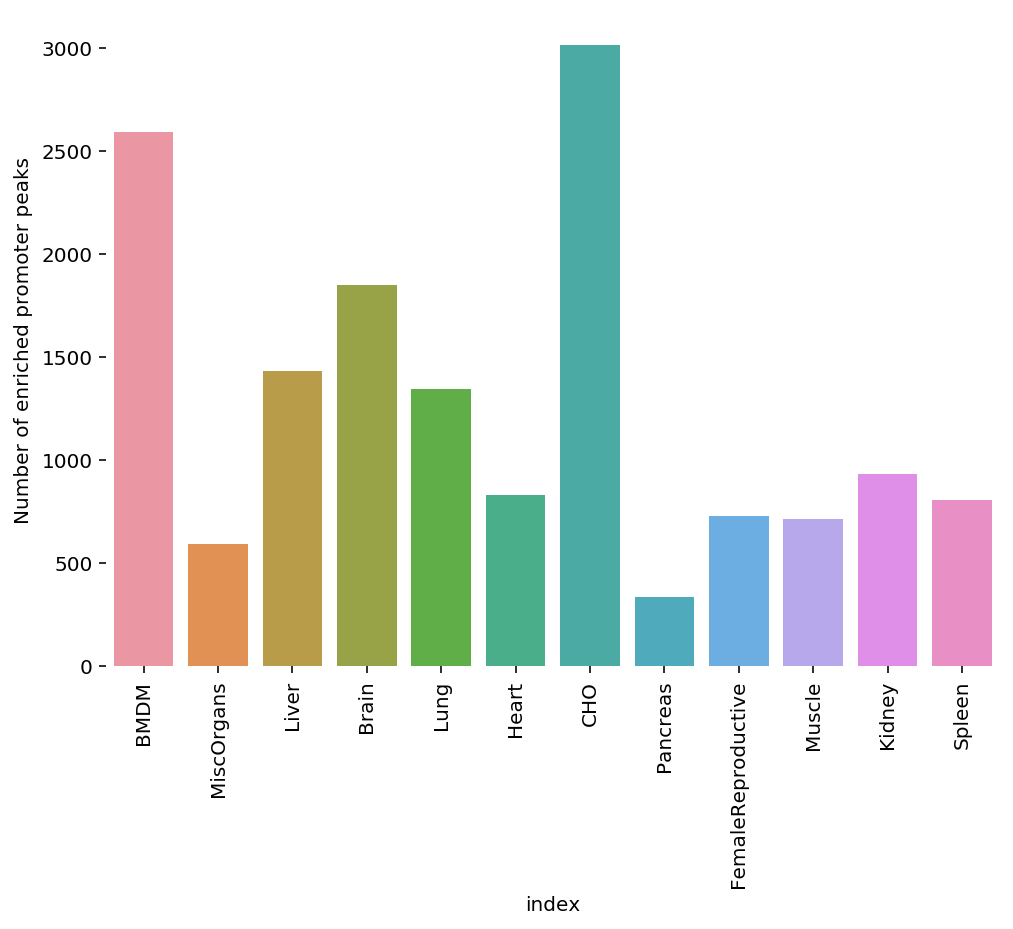

In [18]:
sns.barplot(x='index',y=0, data=(prom_expr_z>2).sum().reset_index())
plt.xticks(rotation=90)
plt.ylabel("Number of enriched promoter peaks")
helper_save(join(prom_enr_dir, "number_of_enriched_peaks_per_tissue"))

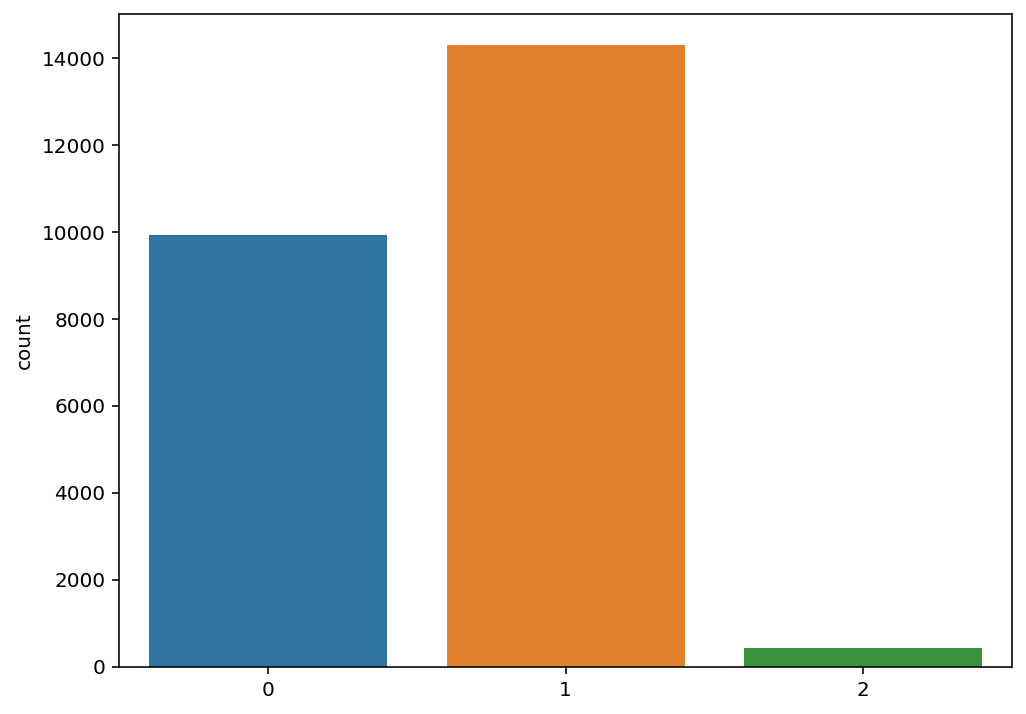

In [19]:
sns.countplot((prom_expr_z>2).sum(axis=1))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

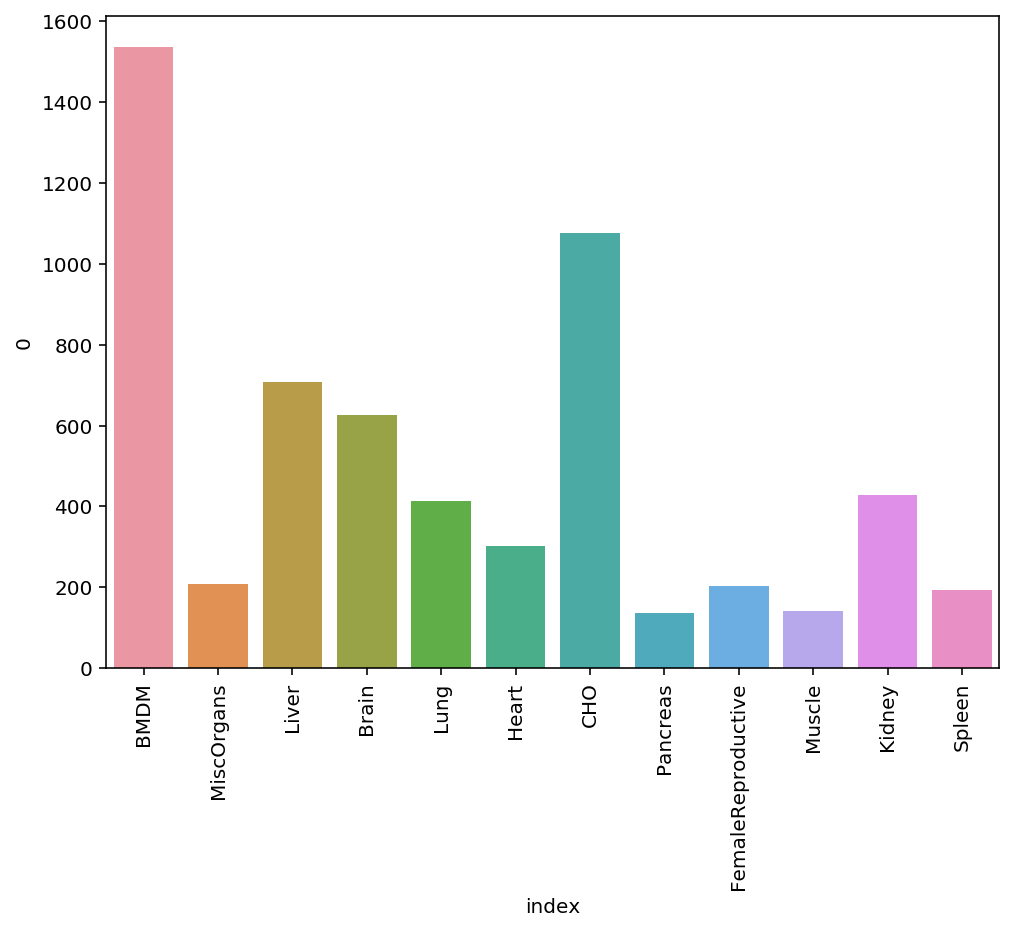

In [20]:
sns.barplot(x='index',y=0, data=(prom_expr_z>3).sum().reset_index())
plt.xticks(rotation=90)

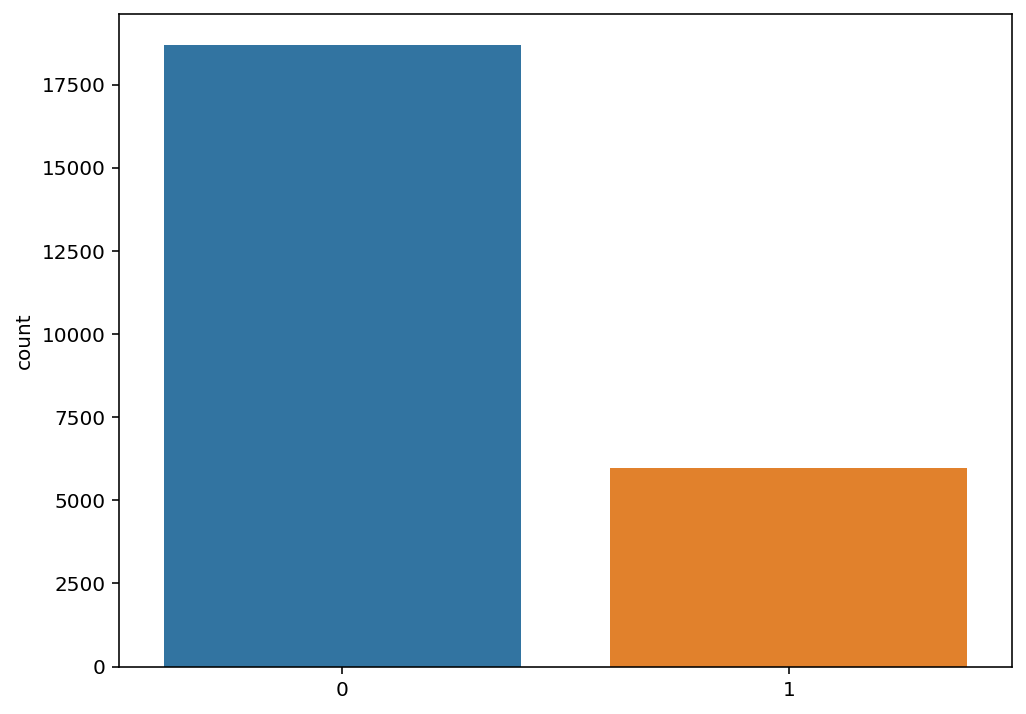

In [21]:
sns.countplot((prom_expr_z>3).sum(axis=1))

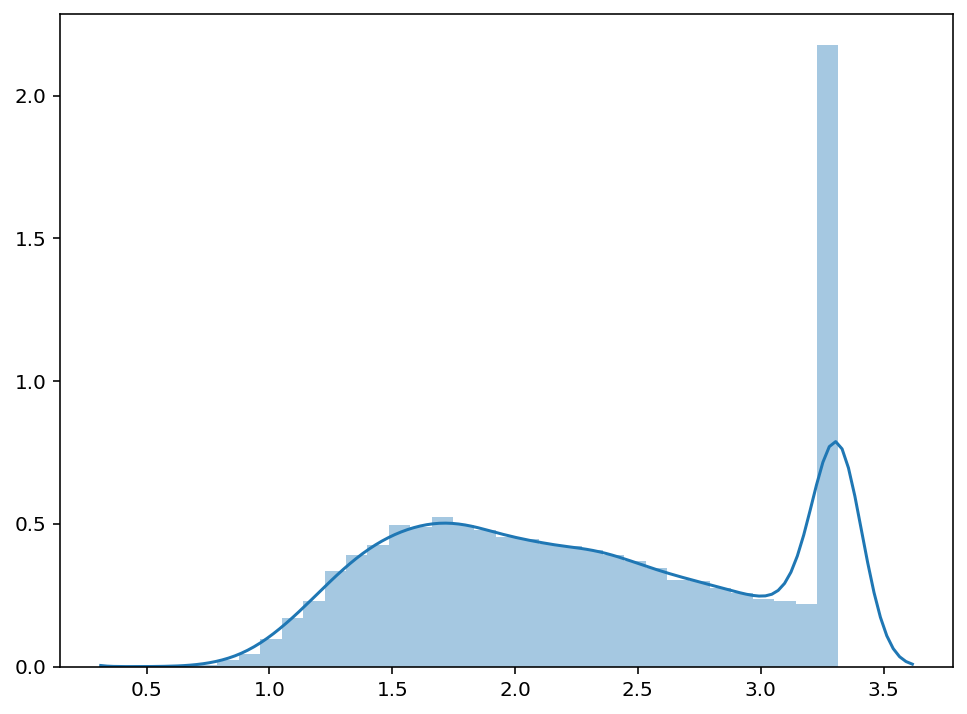

In [22]:
sns.distplot(prom_expr_z.max(axis=1))

Mean-variance plot

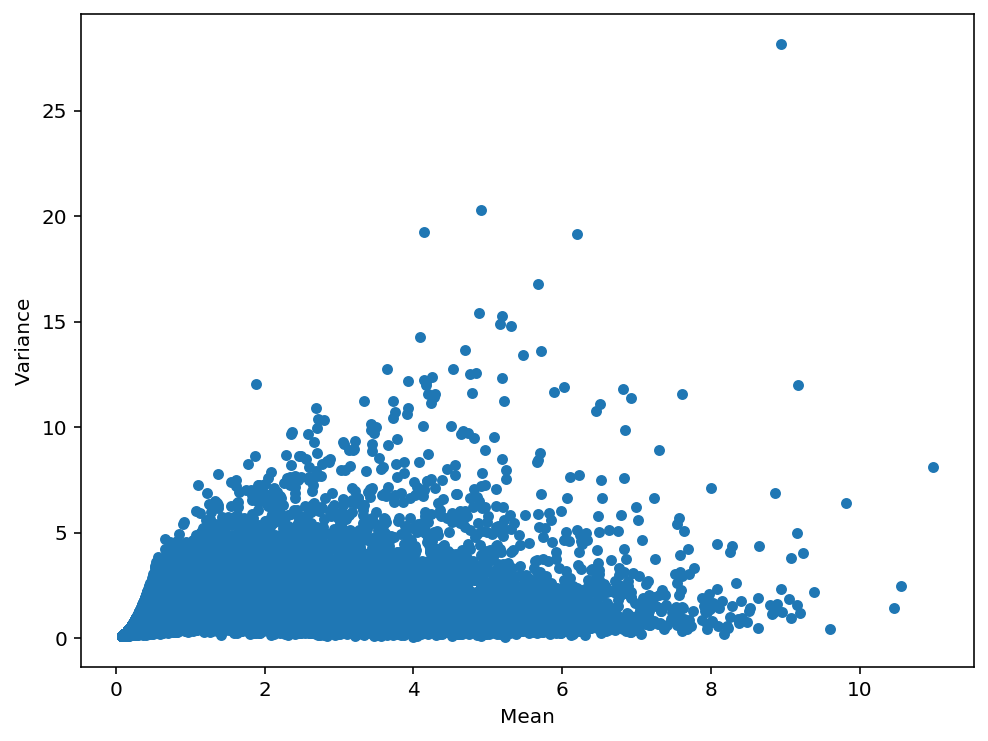

In [23]:
mean_var_df = pd.DataFrame([prom_expr.transpose().mean(), prom_expr.transpose().std(), prom_expr.transpose().var()], index=['Mean', 'Std. dev', 'Variance'])
mean_var_df.transpose().plot.scatter(x='Mean', y='Variance',)

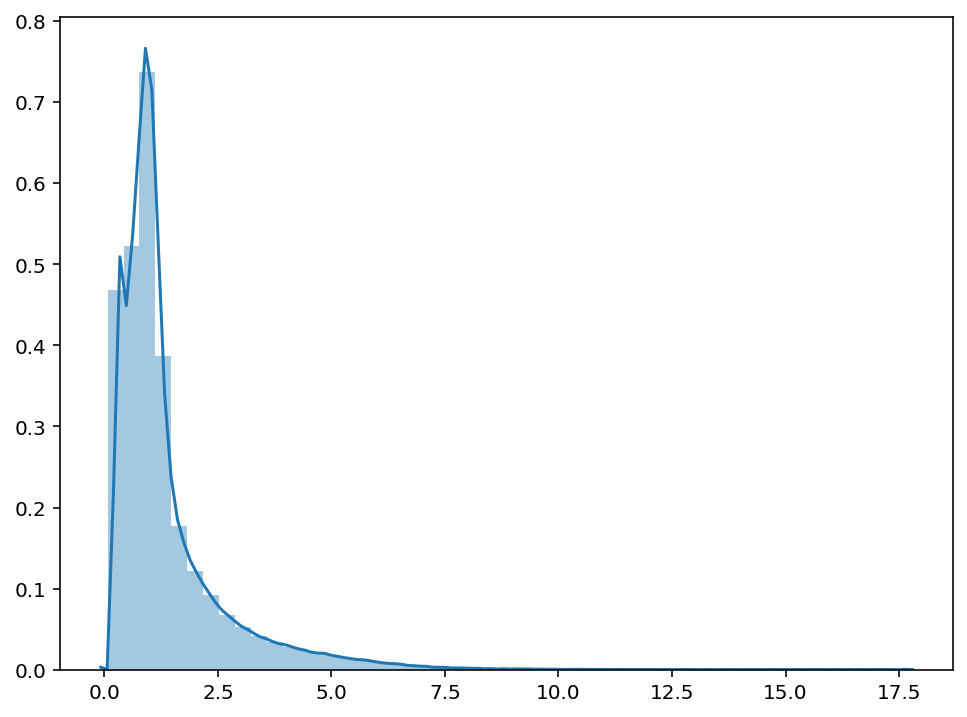

In [24]:
sns.distplot(tissue_expr.max(axis=1))

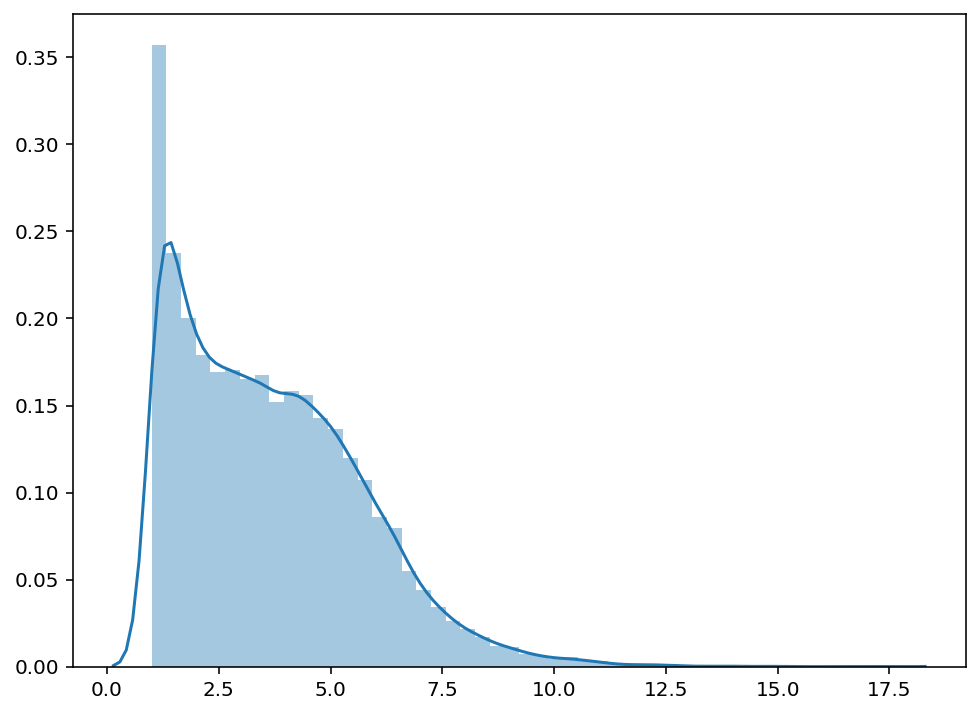

In [25]:
sns.distplot(prom_expr.max(axis=1))

# Loop over tissues

a. Create 'Tissue Enriched' peaks by getting a z-score > 2 (log2 CPM)   
b. Save the anno_peaks filtered on these peaks  
c. Retrieve the sample peaks of this respective tissue (retrieve_tss)  
d. Merge thes sample peak files from those tissues.  
c. Use this merged file for Homer motif finding with GC normalization


In [26]:
def get_sample_peaks(merged_df, sample_df, sample_name, output_f=None, merged_col="Parent files"):
    peaks_to_keep = []
    for ind, val in merged_df.iterrows():
        if sample_name in val[merged_col].split("|"):
            #if use_sample_peaks:
            peaks_to_keep.append(merged_df.loc[ind, sample_name])

#     # original peak file
#     if peaks_dir is not None:
#         sample_df = Homer.read_peak_file(join(peaks_dir,sample_f))
#     else:
#         sample_df = Homer.read_peak_file(sample_f)
    assert(sample_df.shape[0] != 0)
    # Filter to indices to keep
    sample_df_filt = sample_df[sample_df.index.isin(peaks_to_keep)]
    if output_f is not None:
        sample_df_filt.to_csv(output_f, sep='\t')
    return sample_df_filt

In [27]:
for t in prom_expr_z.columns:
    print(t)
    curr_peaks =  prom_expr_z.loc[prom_expr_z[t] > 2].index
    curr_anno = prom_anno.loc[curr_peaks]
    curr_merge = prom_merged.loc[curr_peaks]
    curr_anno.to_csv(join(prom_enr_dir, t + '.prom.enriched_zscore.tsv'))
    sample_peak_files = glob.glob(join(doc['peaks_dir'], t+'*'))
    curr_out = join(prom_enr_dir, t)
    if not os.path.exists(curr_out):
        os.mkdir(curr_out)
    s_p_out = []
    for s_p in sample_peak_files:
        sample_df = read_peak_file(s_p)
        output_f = join(curr_out, basename(s_p))
        print(output_f)
        get_sample_peaks(curr_merge, sample_df, sample_name=basename(s_p), output_f=output_f)
        s_p_out.append(output_f)
    #merge peaks
    out_merge = join(prom_enr_dir, t,t)
    Homer.merge_peaks(s_p_out, output_file=out_merge, dist='given')
    wrap_findMotifs.run_findMotifs(out_merge+'.merge', join(prom_enr_dir,t, 'homer_out'), ref_fa, args=None,  bg=None, 
                                   size=(-300,100), mset=True, num_cores=12, len_mo='large')

BMDM
v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1
v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDMwt_GROCap1_and_BMDMwt_GRO1
mergePeaks -d given -venn v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDM.merge_venn -matrix v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDM.merge_mat -strand v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1 v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDMwt_GROCap1_and_BMDMwt_GRO1 > v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDM.merge
nohup findMotifsGenome.pl v02_de_novo_motifs/alt/promoter_enriched/BMDM/BMDM.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna v02_de_novo_motifs/alt/promoter_enriched/BMDM/homer_out -size -300,100 -len 6,8,10 -p 12  -mset vertebrate > v02_de_novo_motifs/alt/promoter_enriched/BMDM/homer_out.log
MiscOrgans
v02_de_novo_motifs/alt/promoter_enriched/MiscOrgans/MiscOrgans_START1_and_MiscOrgans_startinput1
v02_de_novo_mot

nohup findMotifsGenome.pl v02_de_novo_motifs/alt/promoter_enriched/Pancreas/Pancreas.merge /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna v02_de_novo_motifs/alt/promoter_enriched/Pancreas/homer_out -size -300,100 -len 6,8,10 -p 12  -mset vertebrate > v02_de_novo_motifs/alt/promoter_enriched/Pancreas/homer_out.log
FemaleReproductive
v02_de_novo_motifs/alt/promoter_enriched/FemaleReproductive/FemaleReproductive_START2_and_FemaleReproductive_startinput1
v02_de_novo_motifs/alt/promoter_enriched/FemaleReproductive/FemaleReproductive_START1_and_FemaleReproductive_startinput1
mergePeaks -d given -venn v02_de_novo_motifs/alt/promoter_enriched/FemaleReproductive/FemaleReproductive.merge_venn -matrix v02_de_novo_motifs/alt/promoter_enriched/FemaleReproductive/FemaleReproductive.merge_mat -strand v02_de_novo_motifs/alt/promoter_enriched/FemaleReproductive/FemaleReproductive_START2_and_FemaleReproductive_startinput1 v02_de_novo_motifs/alt/promoter_enriched/FemaleReprod